In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# Markov Chain Monte Carlo

In [2]:
class metropolis(object):
    """Class to conduct Metropolis-Hastings sampling
    
    Parameters
    ----------
    
    log_posterior : func(theta, **kwargs)
        function to return log of posterior
    
    stepsize : np.float32
        proposal distribution scale size
        
    **kwargs : 
        keyword arguments to pass to function  
"""
    def __init__(self, stepsize=0.1, log_posterior=None, **kwargs):
        self._log_posterior = log_posterior
        self.kwargs = kwargs
        self.stepsize = stepsize
        return
    def log_posterior(self, theta=None):
        """Return log of posterior
        
        Parameters
        ----------
        
        theta : ndarray of np.float32
            model parameters
            
        Returns
        -------
        
        log_posterior : np.float32
            log of posterior
"""
        return(self._log_posterior(theta, **(self.kwargs)))
    def initialize(self, theta=None):
        """Initializes the sequence
        
        Parameters
        ----------
        
        theta : ndarray of np.float32
            model parameters to initialize
            
        Notes
        -----
        
        Sets up attributes theta_c, log_posterior_c (the current parameters and their
        log posterior), theta_all, log_posterior_all (history of parameters and
        log posteriors), and nproposals_all (the number of proposals per step).
"""
        self.theta_c = np.array(theta)
        self.theta_all = np.array(self.theta_c, dtype=np.float32).reshape((1, len(theta)))
        self.log_posterior_c = self.log_posterior(theta=self.theta_c)
        self.log_posterior_all = np.array([self.log_posterior_c], dtype=np.float32)
        self.nproposals_all = np.zeros(0, dtype=np.int32)
        return
    def proposal(self):
        """Make a proposal for the next step
        
        Returns
        --------
        
        theta_p : ndarray of np.float32
            proposed step
        
        log_probability_difference : np.float32
            log of ratio of backwards to forward probability distribution for this step            
"""
        ntheta = len(self.theta_c)
        theta_p = np.random.normal(size=ntheta) * self.stepsize
        log_probability_difference = 0.  # ratio of backwards to forwards proposal distribution
        theta_p = self.theta_c + theta_p 
        return(theta_p, log_probability_difference)
    def acceptance_probability(self, log_posterior_p=None, log_probability_difference=None):
        """Acceptance probability
        
        log_posterior_p : np.float32
            log of proposed step's posterior
            
        log_probability_difference : np.float32
            log of proposed step's backwards-to-forwards ratio
"""
        log_ratio = (log_posterior_p - self.log_posterior_c + log_probability_difference)
        return(np.exp(np.min([0., log_ratio])))
    def step(self):
        """Take an MCMC step
        
        Notes
        -----
        
        Updates theta_c, log_posterior_c, theta_all, log_posterior_all, and nproposals_all 
"""
        accepted = False
        nproposals = 1
        while(accepted is False):
            theta_p, lpd = self.proposal()
            log_posterior_p = self.log_posterior(theta_p)
            aprob = self.acceptance_probability(log_posterior_p=log_posterior_p,
                                                log_probability_difference=lpd)
            if(np.random.random() < aprob):
                accepted = True
            nproposals = nproposals + 1
        self.theta_c = theta_p
        self.log_posterior_c = self.log_posterior(theta=self.theta_c)
        self.log_posterior_all = np.append(self.log_posterior_all, self.log_posterior_c)
        self.nproposals_all = np.append(self.nproposals_all, nproposals)
        self.theta_all = np.append(self.theta_all, self.theta_c).reshape(len(self.log_posterior_all),
                                                                         len(self.theta_c))
        return

In [3]:
def log_likelihood(theta, **kwargs):
    """Return log likelihood of line with variance"""
    a0 = theta[0]
    a1 = theta[1]
    logsig = theta[2]
    x = kwargs['x']
    d = kwargs['data']
    m = a0 + a1 * x
    log_likelihood = ((- 0.5 * (m - d)**2 / np.exp(2. * logsig)) 
                      - 0.5 * np.log(2. * np.pi) - logsig).sum()
    return(log_likelihood)

In [31]:
nx = 5000
x = np.random.random(nx) * 5. - 2.5
a0 = 3.
a1 = 1.5
sig = 1.
data = a0 + a1 * x + np.random.normal(size=nx) * sig

<IPython.core.display.Javascript object>


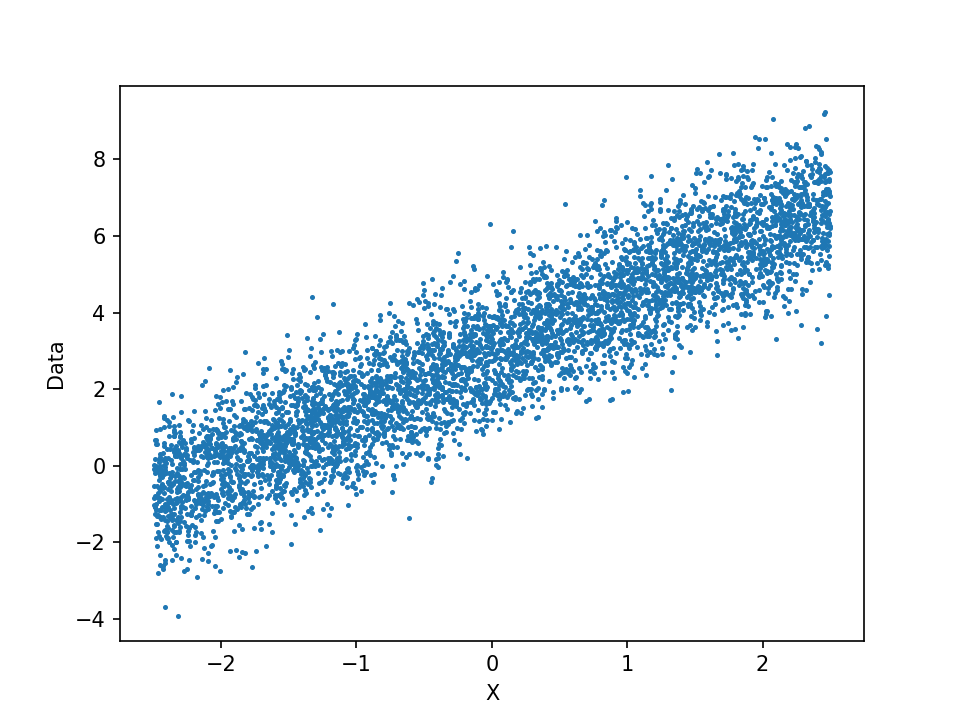

Text(0, 0.5, 'Data')

In [32]:
plt.scatter(x, data, s=2)
plt.xlabel('X')
plt.ylabel('Data')

In [33]:
met = metropolis(log_posterior=log_likelihood, stepsize=0.001,
                 data=data, x=x)

In [34]:
%timeit  for i in range(1000): met.initialize([1., 1., 0.]); met.step()

149 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
met.initialize([1., 1., 0.])
for i in range(100000): met.step()

<IPython.core.display.Javascript object>


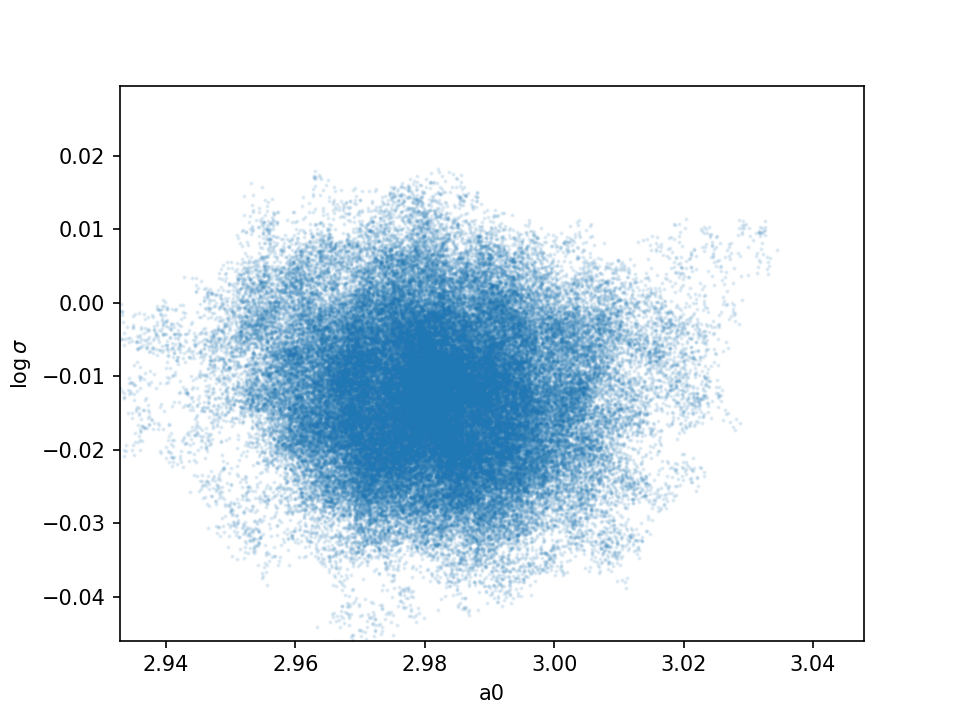

Text(0, 0.5, '$\\log\\sigma$')

In [36]:
plt.scatter(met.theta_all[:, 0], met.theta_all[:, 2], s=1, alpha=0.1)
plt.xlabel('a0')
plt.ylabel('$\log\sigma$')

<IPython.core.display.Javascript object>


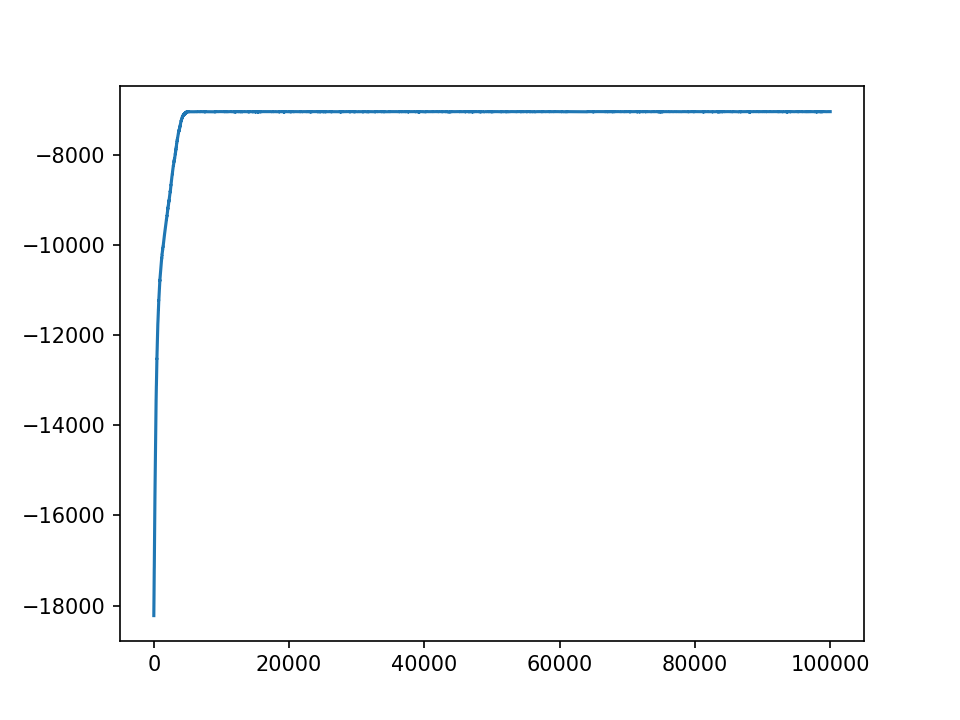

In [37]:
plt.plot(met.log_posterior_all)

We can be much more efficient in calculating the likelihood, because actually we only are acting on the moments of the data:


$$\log L = \sum_i \left[ -\frac{1}{2} \frac{(m_i - d_i)^2}{\sigma^2} - \frac{1}{2}\log(2\pi) - \log\sigma \right]$$

$$\log L = \sum_i \left[ -\frac{1}{2} \frac{(a_0 + a_1 x_i - d_i)^2}{\sigma^2} - \frac{1}{2}\log(2\pi) - \log\sigma \right]$$

$$\log L = N\left(- \frac{1}{2}\log(2\pi) - \log\sigma \right)
- \frac{1}{2} \frac{1}{\sigma^2} \sum_i (a_0 + a_1 x_i - d_i)^2$$

$$\log L = N\left(- \frac{1}{2}\log(2\pi) - \log\sigma \right)
- \frac{1}{2} \frac{1}{\sigma^2} \sum_i \left(a_0^2 + a_1^2 x_i^2 + d_i^2 + 2 a_0 a_1 x_i - 2 a_0 d_i - 2a_1 x_i d_i\right)$$

$$\log L = N\left(- \frac{1}{2}\log(2\pi) - \log\sigma \right)
- N \frac{1}{2} \frac{1}{\sigma^2} \left( a_0^2 + a_1^2 \langle x^2\rangle + \langle d^2 \rangle
+ 2 a_0 a_1 \langle x\rangle - 2 a_0 \langle d\rangle -2 a_1 \langle x d\rangle \right) $$

In [38]:
def log_likelihood_efficient(theta, **kwargs):
    """Return log likelihood of line with variance"""
    a0 = theta[0]
    a1 = theta[1]
    logsig = theta[2]
    N = kwargs['N']
    x_mean = kwargs['x_mean']
    d_mean = kwargs['data_mean']
    x2_mean = kwargs['x2_mean']
    d2_mean = kwargs['data2_mean']
    xd_mean = kwargs['xd_mean']
    log_likelihood = N * (0.5 * np.log(2. * np.pi) - logsig
                          - 0.5 * (1. / np.exp(logsig * 2)) * 
                          (a0**2 + a1**2 * x2_mean + d2_mean + 2. * a0 * a1 * x_mean
                          - 2. * a0 * d_mean - 2. * a1 * xd_mean))
    return(log_likelihood)

In [39]:
N = len(data)
x_mean = x.mean()
data_mean = data.mean()
x2_mean = (x**2).mean()
data2_mean = (data**2).mean()
xd_mean = (data * x).mean()
met = metropolis(log_posterior=log_likelihood_efficient, stepsize=0.1, N=N, x_mean=x_mean,
                 data_mean=data_mean, data2_mean=data2_mean, x2_mean=x2_mean, xd_mean=xd_mean)

In [40]:
%timeit for i in range(1000):  met.initialize([1., 1., 0.]);  met.step() 

51.6 ms ± 981 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
met.initialize([1., 1., 0.])
for i in range(1000): met.step()

<IPython.core.display.Javascript object>


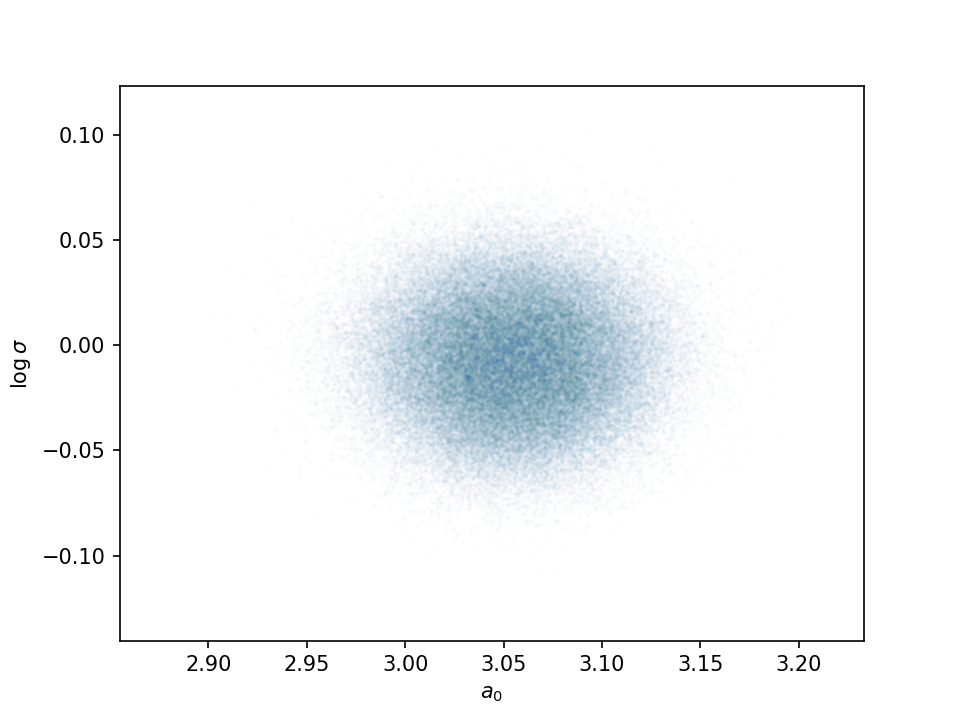

Text(0, 0.5, '$\\log\\sigma$')

In [152]:
plt.scatter(met.theta_all[:, 0], met.theta_all[:, 2], s=1, alpha=0.01)
plt.xlabel('$a_0$')
plt.ylabel('$\log\sigma$')

<IPython.core.display.Javascript object>


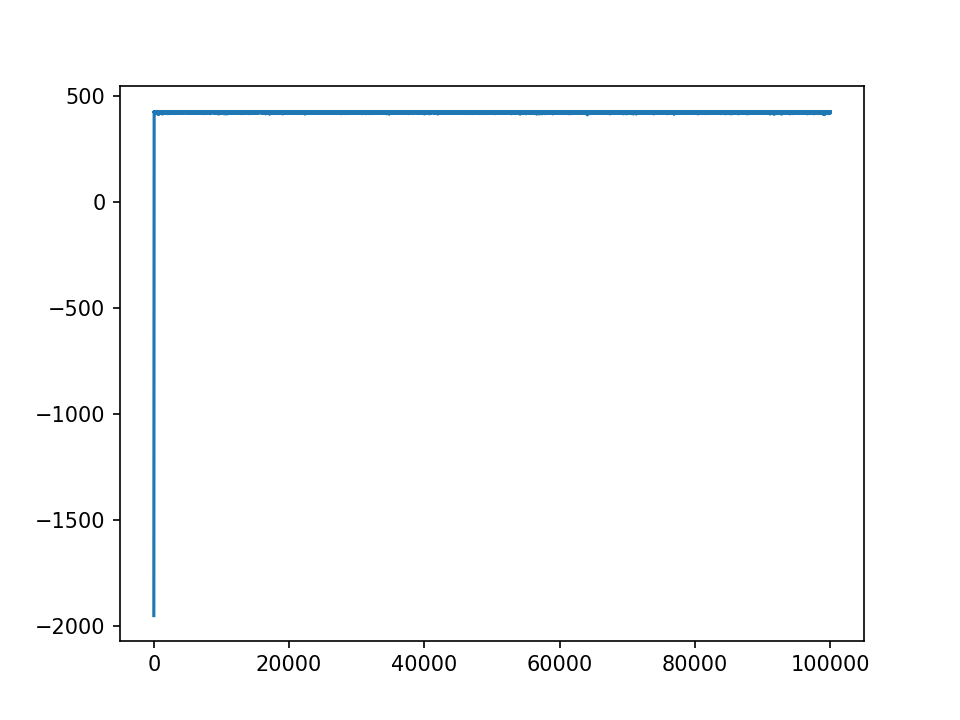

In [153]:
plt.plot(met.log_posterior_all)

In [299]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [307]:
section = met.log_posterior_all[90000:100000]
std = np.std(section)
acorr = autocorr((section - section.mean()))

<IPython.core.display.Javascript object>


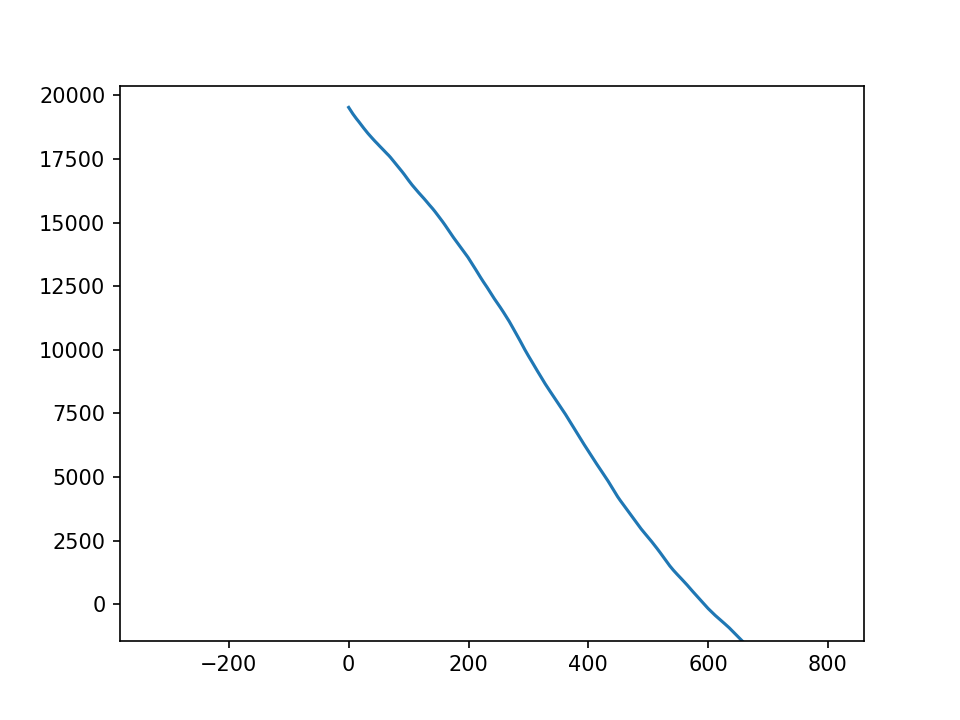

In [309]:
plt.plot((acorr))

In [133]:
h, xh = np.histogram(met.theta_all[10000:, 2], bins=100, range=[-6., 7.2])
xmid = 0.5 * (xh[:-1] + xh[1:])

<IPython.core.display.Javascript object>


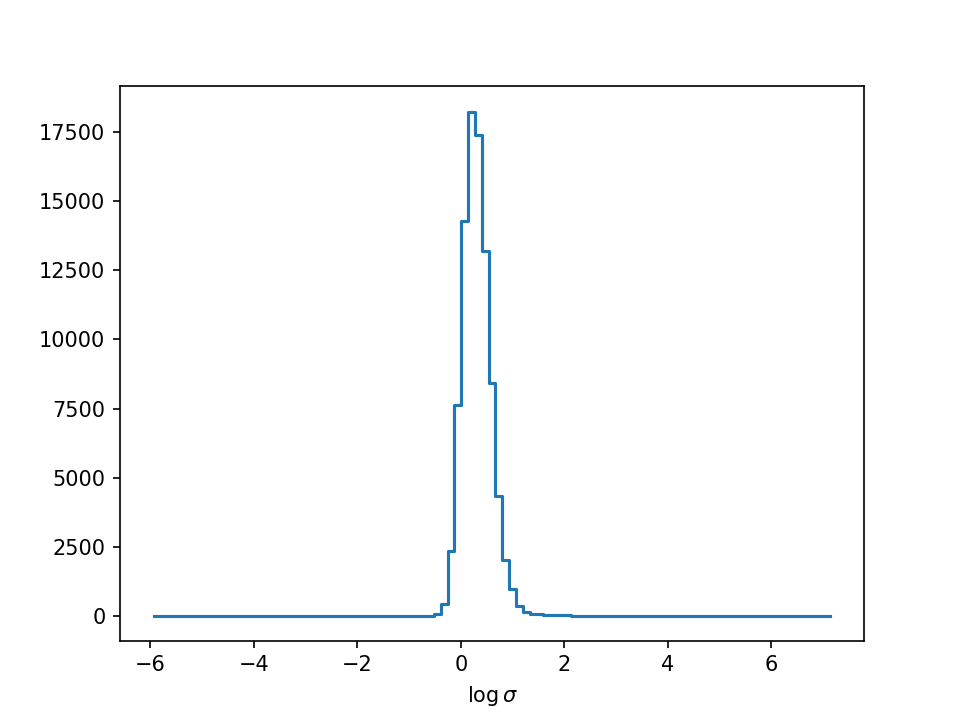

Text(0.5, 0, '$\\log\\sigma$')

In [137]:
plt.step(xmid, h)
plt.xlabel('$\log\sigma$')

<IPython.core.display.Javascript object>


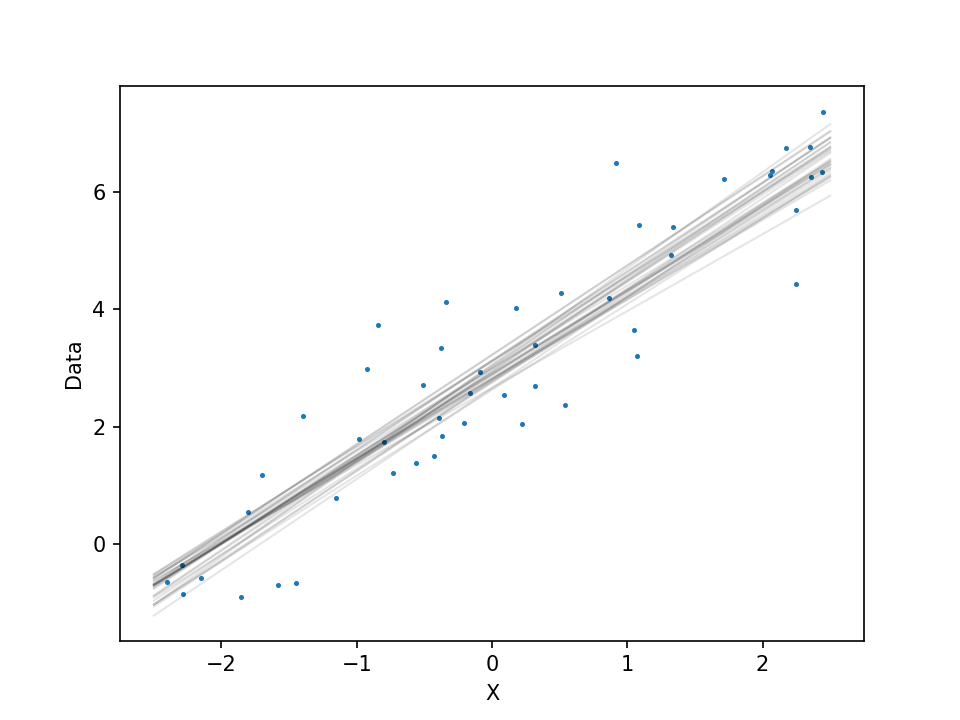

In [333]:
indx = np.arange(amm.theta_all.shape[0], dtype=np.int32)
indx = indx[300:]
np.random.shuffle(indx)
indx = indx[0:30]

plt.scatter(x, data, s=2)
plt.xlabel('X')
plt.ylabel('Data')

for i in indx:
    nmodel = 5 
    xmodel = (np.arange(nmodel) - (nmodel // 2)) / np.float32(nmodel // 2) * 2.5
    model = amm.theta_all[i, 0, 0] + xmodel * amm.theta_all[i, 0, 1]
    plt.plot(xmodel, model, linewidth=1, color='black', alpha=0.1)

In [310]:
class affinemcmc(object):
    """Class to conduct affine-invariant MCMC
    
    Parameters
    ----------
    
    log_posterior : func(theta, **kwargs)
        function to return log of posterior
    
    stepsize : np.float32
        proposal distribution scale size
        
    **kwargs : 
        keyword arguments to pass to function  
"""
    def __init__(self, stepsize=0.1, log_posterior=None, **kwargs):
        self._log_posterior = log_posterior
        self.kwargs = kwargs
        self.stepsize = stepsize
        return
    def log_posterior(self, theta=None):
        """Return log of posterior
        
        Parameters
        ----------
        
        theta : ndarray of np.float32
            model parameters
            
        Returns
        -------
        
        log_posterior : np.float32
            log of posterior
"""
        return(self._log_posterior(theta, **(self.kwargs)))
    def initialize(self, theta=None):
        """Initializes the sequence
        
        Parameters
        ----------
        
        theta : ndarray of np.float32
            model parameters to initialize
            
        Notes
        -----
        
        Sets up attributes theta_c, log_posterior_c (the current parameters and their
        log posterior), theta_all, log_posterior_all (history of parameters and
        log posteriors), and nproposals_all (the number of proposals per step).
"""
        self.nwalkers = theta.shape[0]
        self.theta_c = np.array(theta)
        self.theta_all = np.array(self.theta_c, dtype=np.float32).reshape((1, theta.shape[0], theta.shape[1]))
        self.log_posterior_c = self.log_posterior(theta=self.theta_c)
        self.log_posterior_all = np.array(self.log_posterior_c, dtype=np.float32).reshape((1, theta.shape[0]))
        self.nproposals_all = np.zeros(0, dtype=np.int32)
        return
    def proposal(self, k=None):
        """Make a proposal for the next step
        
        Parameters
        ----------
        
        k : int
            walker to make proposal for
        
        Returns
        --------
        
        theta_p : ndarray of np.float32
            proposed step
        
        log_probability_difference : np.float32
            log of ratio of backwards to forward probability distribution for this step            
"""
        j = k
        while(j == k):
            j = np.int32(np.random.random() * self.nwalkers)
        
        dtheta = self.theta_c[k, :] - self.theta_c[j, :]
        
        a = 2.
        r = np.random.random() 
        z = (r * (np.sqrt(a) - 1. / np.sqrt(a)) + 1. / np.sqrt(a))**2
        
        theta_p = self.theta_c[j, :] + z * dtheta
        
        log_probability_difference = (self.theta_c.shape[1] - 1) * np.log(z)
        return(theta_p, log_probability_difference)
    def acceptance_probability(self, k=None, log_posterior_p=None, log_probability_difference=None):
        """Acceptance probability
        
        log_posterior_p : np.float32
            log of proposed step's posterior
            
        log_probability_difference : np.float32
            log of proposed step's backwards-to-forwards ratio
"""
        log_ratio = (log_posterior_p - self.log_posterior_c[k] + log_probability_difference)
        return(np.exp(np.min([0., log_ratio])))
    def step(self):
        """Take an MCMC step
        
        Notes
        -----
        
        Updates theta_c, log_posterior_c, theta_all, log_posterior_all, and nproposals_all 
"""
        for k in np.arange(self.nwalkers, dtype=np.int32):
            accepted = False
            while(accepted is False):
                theta_p, lpd = self.proposal(k=k)
                log_posterior_p = self.log_posterior(theta_p)
                aprob = self.acceptance_probability(k=k,
                                                    log_posterior_p=log_posterior_p,
                                                    log_probability_difference=lpd)
                if(np.random.random() < aprob):
                    accepted = True
            self.theta_c[k, :] = theta_p
        self.log_posterior_c = self.log_posterior(theta=self.theta_c)
        self.log_posterior_all = np.append(self.log_posterior_all, self.log_posterior_c.reshape(1, self.nwalkers),
                                           axis=0)
        self.theta_all = np.append(self.theta_all, self.theta_c.reshape(1, self.theta_c.shape[0],
                                                                        self.theta_c.shape[1]), axis=0)
        return

In [323]:
def log_likelihood_efficient(theta, **kwargs):
    """Return log likelihood of line with variance"""
    a0 = theta[..., 0]
    a1 = theta[..., 1]
    logsig = theta[..., 2]
    N = kwargs['N']
    x_mean = kwargs['x_mean']
    d_mean = kwargs['data_mean']
    x2_mean = kwargs['x2_mean']
    d2_mean = kwargs['data2_mean']
    xd_mean = kwargs['xd_mean']
    log_likelihood = N * (0.5 * np.log(2. * np.pi) - logsig
                          - 0.5 * (1. / np.exp(logsig * 2)) * 
                          (a0**2 + a1**2 * x2_mean + d2_mean + 2. * a0 * a1 * x_mean
                          - 2. * a0 * d_mean - 2. * a1 * xd_mean))
    return(log_likelihood)

In [324]:
amm = affinemcmc(log_posterior=log_likelihood_efficient, N=N, x_mean=x_mean,
                 data_mean=data_mean, data2_mean=data2_mean, x2_mean=x2_mean, xd_mean=xd_mean)

In [325]:
theta = np.random.normal(size=(10, 3)) * 0.2
theta[:, 0] += 1.
theta[:, 1] += 1.

In [326]:
amm.initialize(theta=theta)

In [327]:
for i in np.arange(1000): amm.step()

In [328]:
print(amm.theta_all.shape)

(1001, 10, 3)


<IPython.core.display.Javascript object>


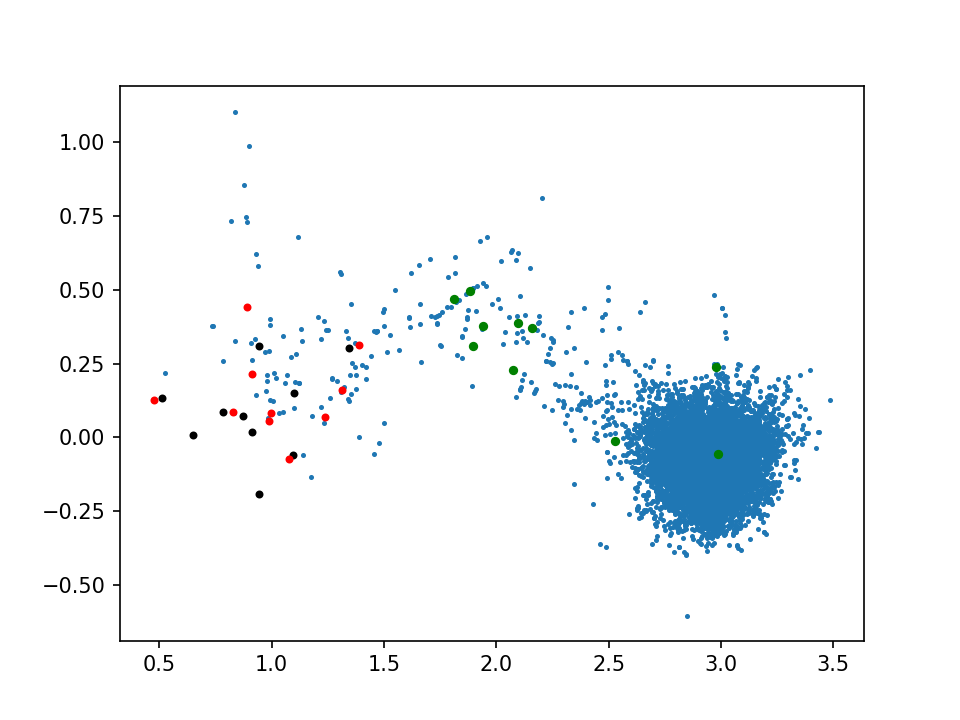

In [329]:
plt.scatter(amm.theta_all[..., 0], amm.theta_all[..., 2], s=2)

istep = 0
plt.scatter(amm.theta_all[istep, :, 0], amm.theta_all[istep, :, 2], s=8, color='black')

istep = 1
plt.scatter(amm.theta_all[istep, :, 0], amm.theta_all[istep, :, 2], s=8, color='red')

istep = 20
plt.scatter(amm.theta_all[istep, :, 0], amm.theta_all[istep, :, 2], s=12, color='green')

<IPython.core.display.Javascript object>


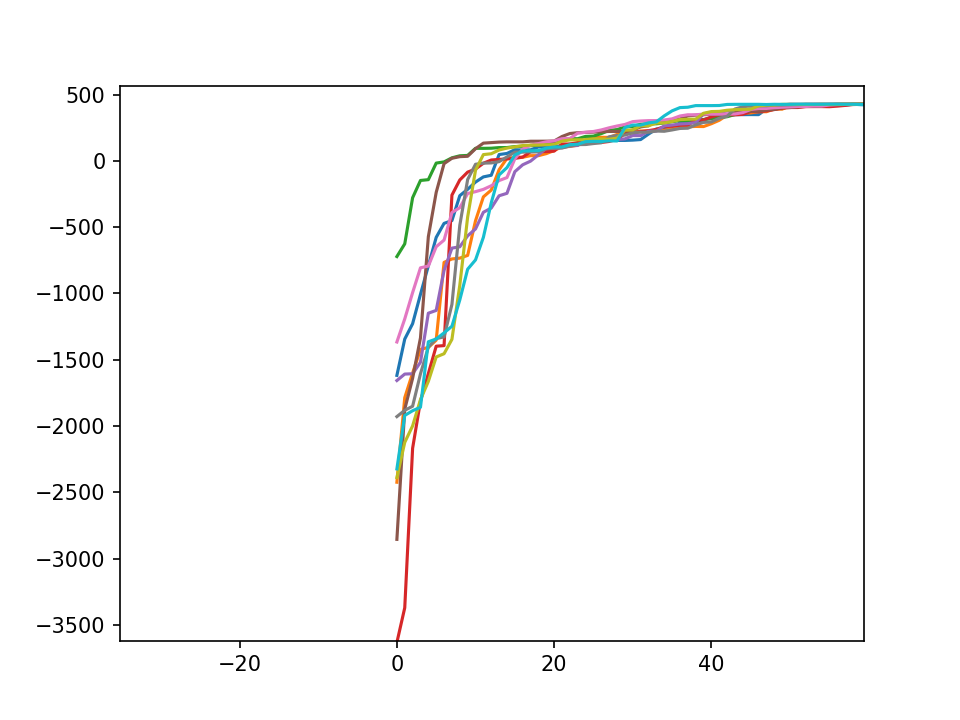

In [318]:
plt.plot(amm.log_posterior_all)